In [44]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the NLTK stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Cell 2: Load the dataset
df = pd.read_csv('factuality_annotations_xsum_summaries.csv')

# Display the first few rows of the dataframe
df.head()
# Cell 3: Data Preprocessing
# Cleaning and tokenizing the text
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

def tokenize(text):
    return text.split()  # Split sentences into individual words

# Apply preprocessing to the 'summary' column
df['summary'] = df['summary'].apply(preprocess)
df['tokens'] = df['summary'].apply(tokenize)

# Drop rows with NaN values
df.dropna(inplace=True)

# Show the cleaned data
df[['summary', 'tokens', 'is_factual']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,summary,tokens,is_factual
0,more than 50 pupils at a bristol academy have ...,"[more, than, 50, pupils, at, a, bristol, acade...",no
1,more than 50 pupils at a bristol academy have ...,"[more, than, 50, pupils, at, a, bristol, acade...",no
2,more than 50 pupils at a bristol academy have ...,"[more, than, 50, pupils, at, a, bristol, acade...",no
3,the wife of a britishiranian woman jailed in i...,"[the, wife, of, a, britishiranian, woman, jail...",no
4,the wife of a britishiranian woman jailed in i...,"[the, wife, of, a, britishiranian, woman, jail...",no


In [45]:
# Cell 4: Encode labels
# Convert 'is_factual' to binary values (1 for 'no' and 0 for 'yes')
df['is_factual'] = df['is_factual'].map({'yes': 0, 'no': 1})

# Display the class distribution
print(df['is_factual'].value_counts())

# Cell 5: Prepare features and labels for model training
X = df['summary']
y = df['is_factual']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the sizes of the train and test sets
print(f'Train size: {len(X_train)}, Test size: {len(X_test)}')


is_factual
1    4982
0     582
Name: count, dtype: int64
Train size: 4451, Test size: 1113


In [47]:
# Cell 6: Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Use the CountVectorizer without a custom tokenizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()

# Display the shape of the vectorized data
print(f'Vectorized Training Data Shape: {X_train_vectorized.shape}')
print(f'Vectorized Test Data Shape: {X_test_vectorized.shape}')


Vectorized Training Data Shape: (4451, 4461)
Vectorized Test Data Shape: (1113, 4461)


In [48]:
# Cell 7: Implement Logistic Regression from scratch
class LogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_predicted]


Accuracy: 0.8958
Precision: 0.8958
Recall: 1.0000
F1 Score: 0.9450


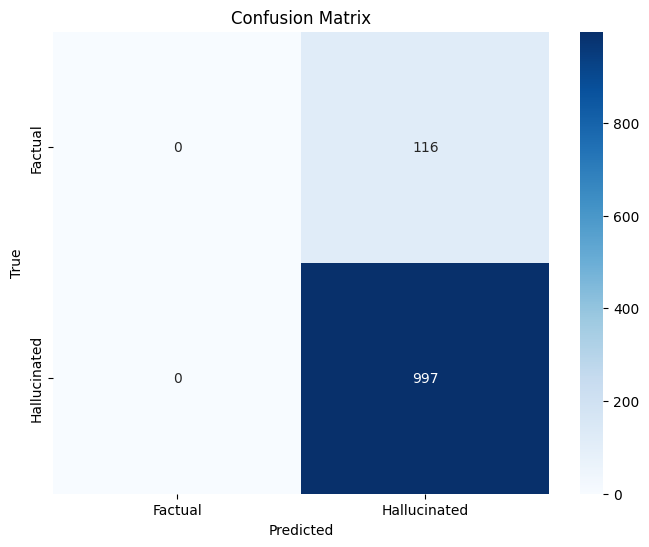

In [50]:
# Cell 8: Model Training
# Train the Logistic Regression model
model = LogisticRegression(learning_rate=0.01, iterations=10)
model.fit(X_train_vectorized, y_train)

# Cell 9: Model Evaluation
# Make predictions on the test set
y_pred = model.predict(X_test_vectorized)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Factual', 'Hallucinated'], yticklabels=['Factual', 'Hallucinated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [52]:

# Cell 10: Cross-Validation
kf = KFold(n_splits=5)
accuracies = []

# Convert X to a DataFrame if it's not already
X_df = pd.DataFrame(X)

for train_index, test_index in kf.split(X_df):
    X_train_fold, X_test_fold = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Vectorize the text data
    X_train_fold_vectorized = vectorizer.fit_transform(X_train_fold['summary']).toarray()
    X_test_fold_vectorized = vectorizer.transform(X_test_fold['summary']).toarray()

    # Train the model
    model.fit(X_train_fold_vectorized, y_train_fold)

    # Make predictions
    y_pred_fold = model.predict(X_test_fold_vectorized)

    # Calculate accuracy
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracies.append(accuracy_fold)

# Report the average accuracy and standard deviation
average_accuracy = np.mean(accuracies)
std_deviation = np.std(accuracies)

print(f'Average Accuracy: {average_accuracy:.4f}')
print(f'Standard Deviation: {std_deviation:.4f}')


Average Accuracy: 0.8954
Standard Deviation: 0.0276


In [53]:
# Cell 11: Error Analysis
# Identify misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_examples = X_test.iloc[misclassified_indices]
misclassified_labels = y_test.iloc[misclassified_indices]

# Display a few misclassified examples
for i in range(min(5, len(misclassified_examples))):
    print(f'Text: {misclassified_examples.iloc[i]}')
    print(f'True Label: {misclassified_labels.iloc[i]}, Predicted Label: {y_pred[misclassified_indices[i]]}')
    print('---')


Text: a world war two bomb has been found in a street in sheffield
True Label: 0, Predicted Label: 1
---
Text: cladding is to be carried out on two highrise buildings in sheffield where cladding is found on the site
True Label: 0, Predicted Label: 1
---
Text: a 23yearold man has died after a shooting outside a house in sheffield
True Label: 0, Predicted Label: 1
---
Text: the belfast giants came from behind to beat nottingham panthers 52 in the first of a elite league campaign
True Label: 0, Predicted Label: 1
---
Text: a woman was assaulted and assaulted in a mcdonalds restaurant in kent police have said
True Label: 0, Predicted Label: 1
---


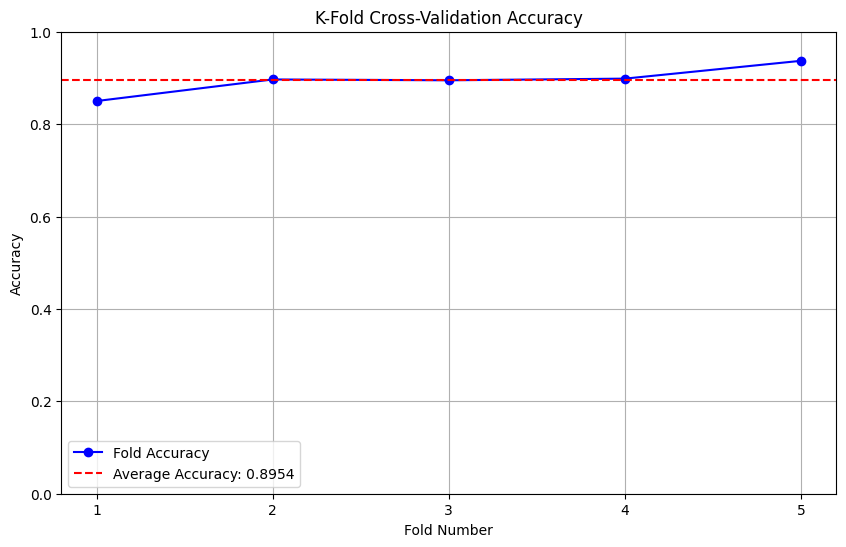

In [54]:

import matplotlib.pyplot as plt

# Plotting the accuracies for each fold
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='b', label='Fold Accuracy')

# Adding average line
average_accuracy = np.mean(accuracies)
plt.axhline(y=average_accuracy, color='r', linestyle='--', label=f'Average Accuracy: {average_accuracy:.4f}')

# Adding labels and title
plt.title('K-Fold Cross-Validation Accuracy')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(accuracies) + 1))  # Set x-ticks to fold numbers
plt.ylim(0, 1)  # Set y-limits to [0, 1]
plt.grid()
plt.legend()
plt.show()


# - Consider using n-grams for feature extraction to capture more context.
# - Experiment with different preprocessing techniques, such as lemmatization.
# - Use more advanced models like Support Vector Machines or neural networks for better performance.